# Tornado Data

My weather variable dataset is located at:
- Latitude: 37.7608
- Longitude: -99.9689

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import get_cmap
import rasterio
from rasterio.plot import show
from math import radians, cos, sin, asin, sqrt

# Loading in data that we processed
df = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/KansasStationProcessed.csv', index_col=0, parse_dates=[0])
tornadoes = pd.read_csv('/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/1950-2021_all_tornadoes.csv')

/Users/evansweeney/Desktop/492_project_local/cmse492_project/tornado/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Tornado Dataset variables

- yr - year
- mo - month
- dy - day
- date - date in yyyy-mo-dy format
- time - time in HH:MM:SS format
- tz - timezone
- mag - magnitude (scale used to classify tornadoes based on damage they cause)
    - F0 (65-85 mph): Light damage, including chimneys knocked down, tree branches broken, and roof shingles lost.
    - F1 (86-110 mph): Moderate damage, including roofs peeled off, mobile homes overturned, and foliage and trees damaged.
    - F2 (111-135 mph): Significant damage, including roofs torn off, mobile homes destroyed, and large trees snapped or uprooted.
    - F3 (136-165 mph): Severe damage, including walls collapsed, and entire neighborhoods affected.
    - F4 (166-200 mph): Devastating damage, including well-built homes leveled, and entire communities destroyed.
    - F5 (201-261 mph): Incredible damage, including homes and buildings swept away, and entire neighborhoods obliterated.
- slat - starting latitude
- slon - starting longitude
- elat - ending latitude
- elon - endling longitude
- len - Length in miles

In [2]:
# columns I'll be using
selected_columns = ['yr', 'mo', 'dy', 'date', 'time', 'tz', 'mag', 'slat', 'slon', 'elat', 'elon', 'len']
tornadoes = tornadoes[selected_columns]

# getting my pandas datetime
tornadoes['Datetime'] = pd.to_datetime(tornadoes['date'] + ' ' + tornadoes['time'])

# placing datetime as 1st column for convience
cols = ['Datetime'] + [col for col in tornadoes.columns if col != 'Datetime']
tornadoes = tornadoes[cols]

# same year selection as my weather dataset, 2011 to 2016
tornadoes = tornadoes[(tornadoes['yr'] >= 2011) & (tornadoes['yr'] <= 2016)]

# won't need these anymore
tornadoes = tornadoes.drop(columns=['yr', 'mo', 'dy', 'tz', 'date', 'time'])


In [3]:
# find average lat and long of each tornado based on starting latitude/longitude and ending latitude/longitude
tornadoes['lat'] = (tornadoes['slat'] + tornadoes['elat']) / 2
tornadoes['long'] = (tornadoes['slon'] + tornadoes['elon']) / 2

tornadoes.drop(columns=['slat', 'slon', 'elat', 'elon'], inplace=True)

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    """
    # decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # The haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956  # radius of earth
    return c * r

# my weather stations coordinates
station_lat = 37.7608
station_lon = -99.9689

# applying distance to weather station function
tornadoes['distance_to_station'] = tornadoes.apply(
    lambda row: haversine(station_lat, station_lon, row['lat'], row['long']), axis=1)

# only keeping tornado instances that are ~70 miles to my weather station
tornadoes = tornadoes[tornadoes['distance_to_station'] <= 70]

tornadoes.reset_index(drop=True, inplace=True)

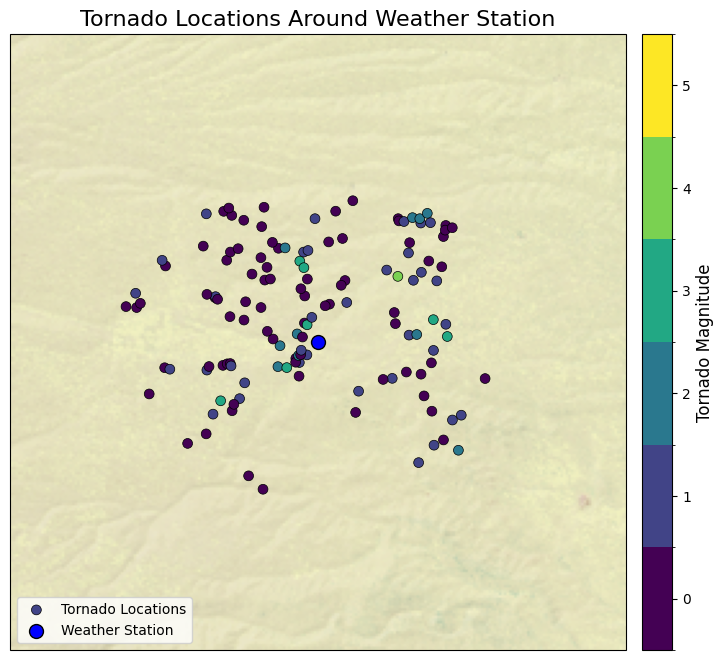

In [4]:
# 
lats = tornadoes['lat']
lons = tornadoes['long']
mags = tornadoes['mag']

# Set the extent for a ~ 70-mile radius
extent_margin = 2
lat_min = station_lat - extent_margin
lat_max = station_lat + extent_margin
lon_min = station_lon - extent_margin
lon_max = station_lon + extent_margin

# 
raster_path = '/Users/evansweeney/Desktop/492_project_local/cmse492_project/data/all_data/NE1_HR_LC_SR.tif'

# creating the map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

with rasterio.open(raster_path) as src:
    show(src, ax=ax, transform=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, facecolor=cfeature.COLORS['land'])

# Define the colormap and normalization
cmap = plt.get_cmap('viridis', 6)  # 6 discrete colors for magnitudes 0 to 5
bounds = np.linspace(-0.5, 5.5, 7)  # Bounds for magnitudes from -0.5 to 5.5
norm = BoundaryNorm(bounds, cmap.N)

# Plot tornado locations with color corresponding to magnitude
scatter = ax.scatter(
    lons,
    lats,
    c=mags,
    cmap=cmap,
    norm=norm,
    s=50,
    edgecolor='k',
    linewidth=0.5,
    transform=ccrs.PlateCarree(),
    label='Tornado Locations'
)

# Add colorbar with ticks at integer magnitudes
cbar = plt.colorbar(
    scatter,
    ax=ax,
    orientation='vertical',
    pad=0.02,
    ticks=range(0, 6)
)
cbar.set_label('Tornado Magnitude', fontsize=12)

# Plot weather station location
ax.scatter(
    station_lon,
    station_lat,
    color='blue',
    s=100,
    edgecolor='k',
    linewidth=1,
    transform=ccrs.PlateCarree(),
    label='Weather Station'
)

# Add title and legend
plt.title('Tornado Locations Around Weather Station', fontsize=16)
plt.legend(loc='lower left')
plt.show()
